In [39]:
import torch
import torchaudio
from dataclasses import dataclass
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModelForCTC, AutoProcessor
import torchaudio.functional as F

torch.random.manual_seed(0)

from pydub import AudioSegment
from pydub.playback import play

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.2.2
2.2.2
cpu


##### Whenever we perform ASR , it is standard practice to make the separator of words as "|" character. this should also come as the beginning and ending of each sentence.

In [40]:
transcript_original = "|अब्राहम|की|सन्तान|दाऊद|की|सन्तान|यीशु|मसीह|की|वंशावली|अब्राहम|से|इसहाक|उत्पन्न|हुआ|"
SPEECH_FILE = "/Users/Nishant/Desktop/sarvam/10s_sample.mp3" # 10 second sample taken from the original audio, first audio file

In [41]:
DEVICE_ID = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "ai4bharat/indicwav2vec-hindi"

model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE_ID)
processor = AutoProcessor.from_pretrained(MODEL_ID)

Some weights of the model checkpoint at ai4bharat/indicwav2vec-hindi were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at ai4bharat/indicwav2vec-hindi and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this mode

In [82]:
labels = list(processor.tokenizer.get_vocab().keys())
print(labels)

['<s>', '<pad>', '</s>', '<unk>', '|', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ळ']


In [83]:
first_label = labels[0]
blank_token = labels[4]
labels[0] = blank_token
labels[4] = first_label
labels = tuple(labels)
print(labels)

('|', '<pad>', '</s>', '<unk>', '<s>', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', 'ळ')


In [84]:
from datasets import load_dataset, Audio, Dataset

audio_dataset = Dataset.from_dict(
    {
        "audio": [
            SPEECH_FILE,
        ]
    }
).cast_column("audio", Audio())
audio_dataset[0]["audio"]

{'path': '/Users/Nishant/Desktop/sarvam/10s_sample.mp3',
 'array': array([ 0.        ,  0.        ,  0.        , ..., -0.04459506,
        -0.03979012, -0.03902366]),
 'sampling_rate': 24000}

In [106]:
sample = audio_dataset[0]
# shape of sample = (237600,)
resampled_audio = F.resample(
    torch.tensor(sample["audio"]["array"]), 24000, 16000
).numpy()
# (79200,) : shape of resampled audio

input_values = processor(resampled_audio, return_tensors="pt").input_values
# torch.Size([1, 79200]) shape of input values

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [107]:
with torch.no_grad():
    logits = model(input_values.to(DEVICE_ID)).logits.cpu()

# logits = logits.squeeze()
prediction_ids = torch.argmax(logits, dim=-1)
print(prediction_ids.shape)
print(logits.shape)

torch.Size([1, 494])
torch.Size([1, 494, 68])


Shape of logits is 

(batch_size, x , vocab_size)

vocab_size is 68

In [108]:
emission = logits.squeeze()
emission.shape

torch.Size([494, 68])

This plot shows how the logits correspinding to the characters present in the vocab change with each frame. Here there are 247 frames in the output for a 10 second audio clip. Which means 1 frame will correspind to 10*1000/247 = 40.485 milli second.

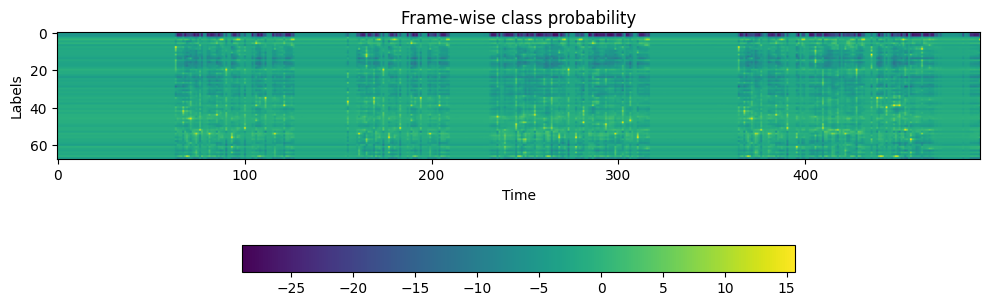

In [109]:
def plot():
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figure size
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [110]:
transcript = transcript_original
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

[('|', 0), ('अ', 8), ('ब', 42), ('्', 66), ('र', 46), ('ा', 54), ('ह', 52), ('म', 44), ('|', 0), ('क', 20), ('ी', 56), ('|', 0), ('स', 51), ('न', 39), ('्', 66), ('त', 35), ('ा', 54), ('न', 39), ('|', 0), ('द', 37), ('ा', 54), ('ऊ', 13), ('द', 37), ('|', 0), ('क', 20), ('ी', 56), ('|', 0), ('स', 51), ('न', 39), ('्', 66), ('त', 35), ('ा', 54), ('न', 39), ('|', 0), ('य', 45), ('ी', 56), ('श', 49), ('ु', 57), ('|', 0), ('म', 44), ('स', 51), ('ी', 56), ('ह', 52), ('|', 0), ('क', 20), ('ी', 56), ('|', 0), ('व', 48), ('ं', 6), ('श', 49), ('ा', 54), ('व', 48), ('ल', 47), ('ी', 56), ('|', 0), ('अ', 8), ('ब', 42), ('्', 66), ('र', 46), ('ा', 54), ('ह', 52), ('म', 44), ('|', 0), ('स', 51), ('े', 61), ('|', 0), ('इ', 10), ('स', 51), ('ह', 52), ('ा', 54), ('क', 20), ('|', 0), ('उ', 12), ('त', 35), ('्', 66), ('प', 40), ('न', 39), ('्', 66), ('न', 39), ('|', 0), ('ह', 52), ('ु', 57), ('आ', 9), ('|', 0)]


In [111]:
len(tokens)

84

In [70]:
num_frame = emission.size(0) # 169
num_tokens = len(tokens) # number of characters in transcript 84

trellis = torch.zeros((num_frame, num_tokens))

In [71]:
blank_id = 4

In [73]:
emission.shape

torch.Size([247, 68])

In [72]:
emission[1:, 4].shape

torch.Size([246])

tensor([ 1,  3,  6, 10, 15])

In [77]:
trellis[-num_tokens + 1 :, 0].shape

torch.Size([83])

In [78]:
trellis[1:, 0].shape

torch.Size([246])

In [112]:
def get_trellis(emission, tokens, blank_id=0):
    """
    Returns the trellis for the given emission and tokens.
    Trellis is of shape (num_frame, num_tokens)
    blank_id is the index of the blank token in the tokens list
    """
    num_frame = emission.size(0) # 169
    num_tokens = len(tokens) # number of characters in transcript 84

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens, blank_id = 0)

In [113]:
print(trellis.shape)

torch.Size([494, 84])


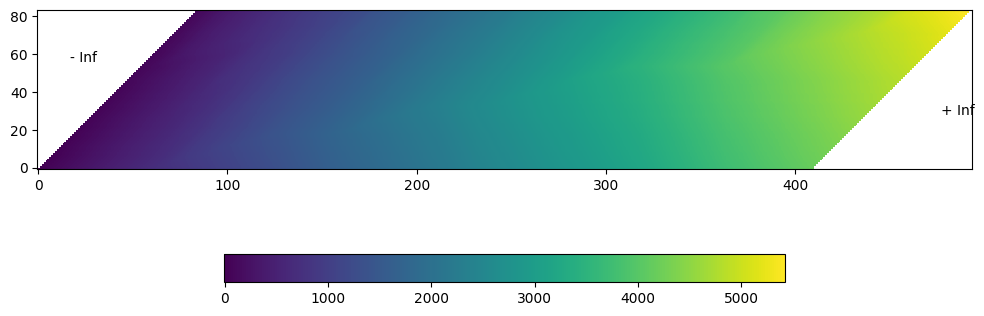

In [114]:
def plot():
    fig, ax = plt.subplots(figsize=(10, 6))
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()



plot()

In [115]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=0, score=113120.671875)
Point(token_index=0, time_index=1, score=115565.390625)
Point(token_index=0, time_index=2, score=115819.4921875)
Point(token_index=0, time_index=3, score=115909.875)
Point(token_index=0, time_index=4, score=115452.8125)
Point(token_index=0, time_index=5, score=115032.6484375)
Point(token_index=0, time_index=6, score=114459.890625)
Point(token_index=0, time_index=7, score=113786.3046875)
Point(token_index=0, time_index=8, score=112910.5)
Point(token_index=0, time_index=9, score=111911.265625)
Point(token_index=0, time_index=10, score=111201.4453125)
Point(token_index=0, time_index=11, score=110235.625)
Point(token_index=0, time_index=12, score=109609.7890625)
Point(token_index=0, time_index=13, score=108970.046875)
Point(token_index=0, time_index=14, score=108407.109375)
Point(token_index=0, time_index=15, score=108016.390625)
Point(token_index=0, time_index=16, score=107577.8359375)
Point(token_index=0, time_index=17, score=107167

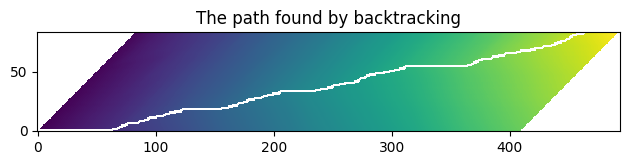

In [116]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

In [117]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(121213.55): [    0,    64)
अ	(59416.56): [   64,    68)
ब	(150953.07): [   68,    70)
्	(387296.51): [   70,    72)
र	(48812.34): [   72,    75)
ा	(70808.22): [   75,    77)
ह	(66403.70): [   77,    86)
म	(29969.65): [   86,    87)
|	(169063.92): [   87,    91)
क	(289911.66): [   91,    94)
ी	(107261.70): [   94,    95)
|	(162694.00): [   95,   101)
स	(60509.71): [  101,   107)
न	(21504.32): [  107,   109)
्	(356529.62): [  109,   112)
त	(136564.83): [  112,   117)
ा	(97720.21): [  117,   122)
न	(52720.61): [  122,   123)
|	(136225.84): [  123,   156)
द	(157530.45): [  156,   162)
ा	(46124.89): [  162,   166)
ऊ	(59191.07): [  166,   170)
द	(101071.69): [  170,   171)
|	(170670.59): [  171,   175)
क	(434389.91): [  175,   178)
ी	(82077.89): [  178,   179)
|	(163018.57): [  179,   184)
स	(57220.44): [  184,   190)
न	(21783.18): [  190,   192)
्	(299691.09): [  192,   195)
त	(123690.45): [  195,   200)
ा	(99532.69): [  200,   205)
न	(55238.66): [  205,   206)
|	(83806.33): [  206,   23

/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3139461363.py:38: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3139461363.py:38: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3139461363.py:38: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3139461363.py:38: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3139461363.py:38: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/31394613

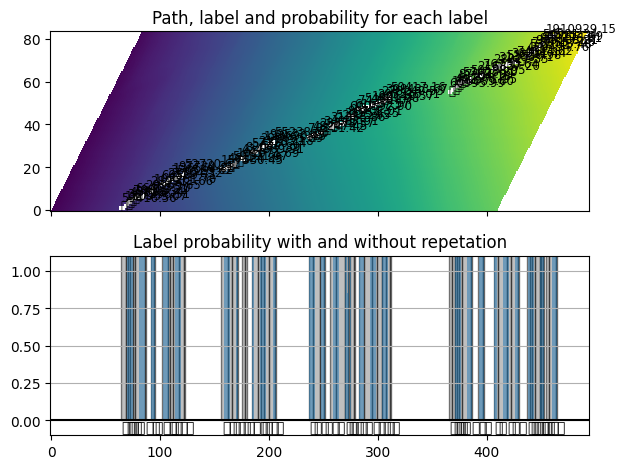

In [118]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

In [119]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(
                    seg.length for seg in segs
                )
                words.append(
                    Segment(word, segments[i1].start, segments[i2 - 1].end, score)
                )
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

अब्राहम	(96948.77): [   64,    87)
की	(244249.17): [   91,    95)
सन्तान	(122718.25): [  101,   123)
दाऊद	(97834.55): [  156,   171)
की	(346311.91): [  175,   179)
सन्तान	(111696.21): [  184,   206)
यीशु	(47835.50): [  236,   251)
मसीह	(43202.61): [  256,   273)
की	(492805.83): [  274,   279)
वंशावली	(173237.87): [  282,   312)
अब्राहम	(107240.05): [  365,   386)
से	(193486.11): [  391,   397)
इसहाक	(38417.49): [  406,   429)
उत्पन्न	(659980.54): [  436,   452)
हुआ	(791738.65): [  454,   464)


In [120]:
waveform = torch.tensor(resampled_audio).unsqueeze(dim = 0)
sample_rate = 16000

In [127]:
waveform.shape

torch.Size([1, 158400])

/Users/Nishant/miniconda3/envs/sarvam/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3784634883.py:46: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3784634883.py:46: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3784634883.py:46: UserWarning: Glyph 2348 (\N{DEVANAGARI LETTER BA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3784634883.py:46: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/var/folders/d6/gqr_4fkx0hqbg4543bf562ym0000gp/T/ipykernel_1573/3784634883.py:46: U

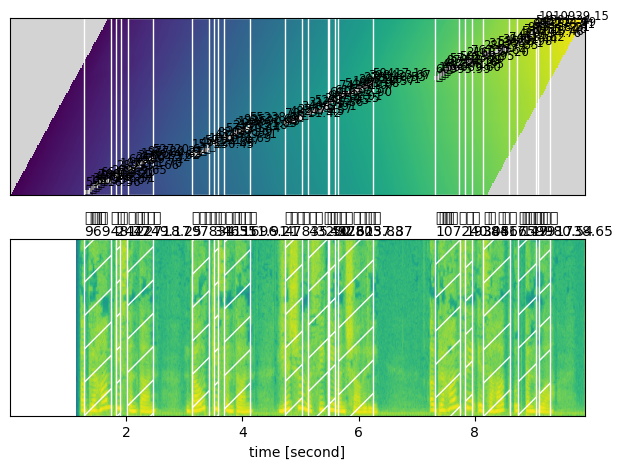

In [121]:
def plot_alignments(
    trellis, segments, word_segments, waveform, sample_rate=16_000
):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(
            word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none"
        )

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = waveform.size(0) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(
            f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False
        )

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(
                seg.label,
                (seg.start * ratio, sample_rate * 0.55),
                annotation_clip=False,
            )
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)

In [123]:
import IPython

def display_segment(i):
    ratio = waveform.size(1) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(x0, x1)
    print(
        f"{word.label} ({word.score:.2f}): {x0 / 16_000:.3f} - {x1 / 16_000:.3f} sec"
    )
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=16_000)

In [124]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

|अब्राहम|की|सन्तान|दाऊद|की|सन्तान|यीशु|मसीह|की|वंशावली|अब्राहम|से|इसहाक|उत्पन्न|हुआ|


In [125]:
for i in range(len(word_segments)):
    display_segment(i)
    
    

20521 27896
अब्राहम (96948.77): 1.283 - 1.744 sec
29178 30461
की (244249.17): 1.824 - 1.904 sec
32385 39439
सन्तान (122718.25): 2.024 - 2.465 sec
50021 54830
दाऊद (97834.55): 3.126 - 3.427 sec
56113 57395
की (346311.91): 3.507 - 3.587 sec
58999 66053
सन्तान (111696.21): 3.687 - 4.128 sec
75672 80482
यीशु (47835.50): 4.729 - 5.030 sec
82085 87536
मसीह (43202.61): 5.130 - 5.471 sec
87857 89460
की (492805.83): 5.491 - 5.591 sec
90422 100042
वंशावली (173237.87): 5.651 - 6.253 sec
117036 123770
अब्राहम (107240.05): 7.315 - 7.736 sec
125373 127297
से (193486.11): 7.836 - 7.956 sec
130182 137557
इसहाक (38417.49): 8.136 - 8.597 sec
139802 144932
उत्पन्न (659980.54): 8.738 - 9.058 sec
145574 148780
हुआ (791738.65): 9.098 - 9.299 sec


In [126]:
display_segment(9)

90422 100042
वंशावली (173237.87): 5.651 - 6.253 sec


In [25]:
sound_file = AudioSegment.from_mp3(SPEECH_FILE)

display(sound_file)

In [105]:
sound_file_part= sound_file[2826:3206]
display(sound_file_part)